# Sequential Sampling using Dimensionality Reduction

This section provides an example implementation of the usage of dimensionality reduction along with expected improvement (EI) to perform exploration and exploitation of a high-dimensional function. The dimensionality reduction methods used in this section are principal component analysis (PCA) and kernel principal component analysis. The example problem used to demonstrate sequential sampling using dimensionality reduction is the 10-dimensional Styblinski-Tang function. The problem statement can be written as

$$f(\textbf{x}) = \frac{1}{2} \sum_{i=1}^{10} (x_i^4 - 16x_i^2 + 5x_i)$$
$$ -5 \leq x_i \leq 5, \quad i = 1,...,10 $$


The global minimum of the function is $f(\textbf{x}^*)=-391.6599$ at $\textbf{x}^*=(-2.904,...,-2.904)$.

In [2]:
# Imports
import numpy as np
import time
from sklearn.decomposition import PCA, KernelPCA
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from scipy.stats import norm as normal

The block of code below defines the Styblinski-Tang function for any number of dimensions. We will be using the 10-dimensional version of the function and therefore, need to provide a 10-dimensional input to this function.

In [5]:
# Styblinski-Tang function
def f(x):
    """
        Function which calculates the Styblinski-Tang function value at given x.
        
        Input:
        x - 1D/2D numpy array
    """

    # Number of dimensions of input
    dim = x.ndim

    # To ensure n x 2
    if dim == 1:
        x = x.reshape(1,-1)

    innersum = np.zeros((x.shape[0], x.shape[1], 3))

    innersum[:,:,0] = x**4
    innersum[:,:,1] = -16*x**2
    innersum[:,:,2] = 5*x

    outersum = np.sum(innersum, axis=2)
    
    y = 0.5*np.sum(outersum, axis=1, keepdims=True)
    
    if dim == 1:
        y = y.reshape(-1,)
    
    return y

## Sequential Sampling using Expected Improvement (EI)

The blocks of code below will perform sequential sampling using the standard EI that was demonstrated in the Sequential Sampling section of the Jupyter Book. The random state for the generation of initial samples is fixed since the results obtained using EI will be compared to those obtained using the dimensionality reduction methods and therefore, it is important for each of the algorithms to start with the same initial samples. However, the results can still vary if the sequential sampling is re-run since the seed for differential evolution has not been set. For a fair comparison, the convergence criterion of the sampling is set as the maximum number of iterations. This is so that EI and the other methods will run for the same number of iterations and perform the same number of infills. In the end, the best objective value can be compared to compare the performance of the algorithms. As you will observe, it is also quite difficult for the max EI to meet the convergence criteria for a high-dimensional function. In such cases, the aim is to obtain the best possible value of the objective function in the shortest amount of sampling iterations.  

In [4]:
# Setting number of dimensions for the problem - 10D Styblinski-Tang Function
ndim = 10

# Defining bounds
lb = np.array([-5]*ndim)
ub = np.array([5]*ndim)
    
# Problem class
class EI(Problem):

    def __init__(self, sm, ymin):
        super().__init__(n_var=ndim, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model
        self.ymin = ymin

    def _evaluate(self, x, out, *args, **kwargs):

        # Standard normal
        numerator = self.ymin - self.sm.predict_values(x)
        denominator = np.sqrt( self.sm.predict_variances(x) )
        z = numerator / denominator
        
        # Computing expected improvement
        # Negative sign because we want to maximize EI
        out["F"] = - ( numerator * normal.cdf(z) + denominator * normal.pdf(z) )

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

The block of code below creates 20 training points and performs the sequential sampling process using EI. The convergence criterion is set at a maximum number of 45 iterations.

In [4]:
# Setting a random state to allow a fair comparison between the different methods
random_state = 20
xlimits = np.column_stack((lb,ub))
sampler = LHS(xlimits=xlimits, criterion='ese', random_state = 20)

# Training data
num_train = 20
xtrain = sampler(num_train)
ytrain = f(xtrain)

# Variables
itr = 0
max_itr = 45
tol = 1e-3
max_EI = [1]
ybest = []
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
t1 = time.time()
while itr < max_itr:
        
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm.set_training_values(xtrain, ytrain)
    
    # Creating surrogate model
    sm.train()

    # Find the best observed sample
    ybest.append(np.min(ytrain))

    # Find the minimum of surrogate model
    result = minimize(EI(sm, ybest[-1]), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = f(result.X.reshape(1,-1))

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[np.argmin(ytrain)].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[np.argmin(ytrain)]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))

    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number

t2 = time.time()
# Printing the final results
print("\nBest obtained point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))

# Storing results
ei_ybest = ybest
ei_xbest = xbest
ei_time = t2 - t1


Iteration 1
Maximum EI: 29.9348389478
Best observed value: -150.53602901269912

Iteration 2
Maximum EI: 14.313598360026237
Best observed value: -150.53602901269912

Iteration 3
Maximum EI: 22.179316153376632
Best observed value: -150.53602901269912

Iteration 4
Maximum EI: 47.68078740723258
Best observed value: -150.53602901269912

Iteration 5
Maximum EI: 27.92762674314964
Best observed value: -150.53602901269912

Iteration 6
Maximum EI: 35.52459213127647
Best observed value: -150.53602901269912

Iteration 7
Maximum EI: 21.340778116409087
Best observed value: -192.73791154099587

Iteration 8
Maximum EI: 31.383882396972645
Best observed value: -192.73791154099587

Iteration 9
Maximum EI: 100.85633714502279
Best observed value: -192.73791154099587

Iteration 10
Maximum EI: 122.32202034153798
Best observed value: -192.73791154099587

Iteration 11
Maximum EI: 80.8309296006207
Best observed value: -192.73791154099587

Iteration 12
Maximum EI: 31.260095296453123
Best observed value: -192.73

The block of code below will plot the history of the best observed value of the objective function against the number of iterations.

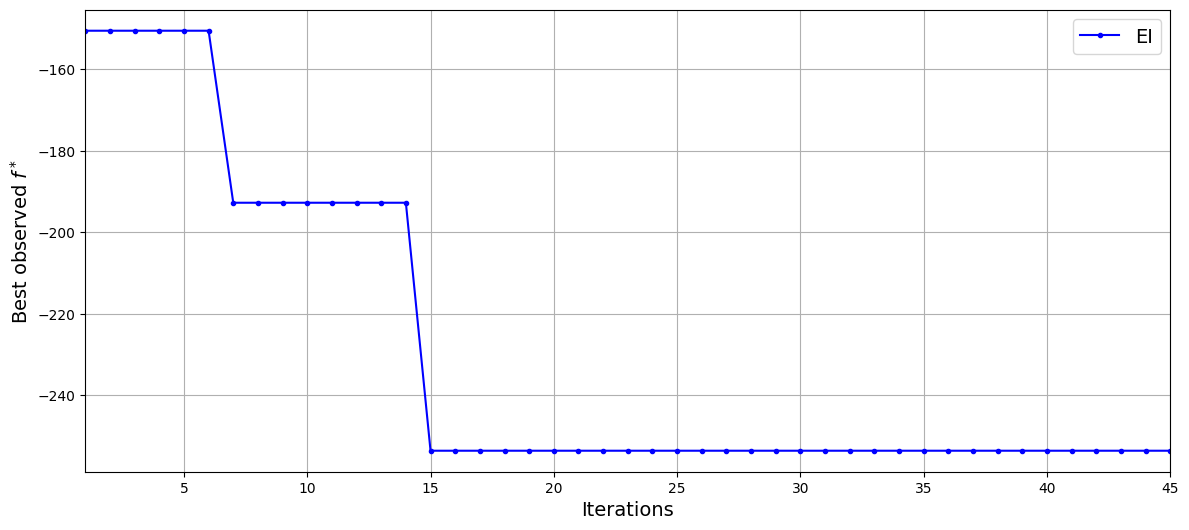

In [5]:
# Plotting variation of best value of objective function
fig, ax = plt.subplots(1, 1, figsize=(14,6))
ax.plot(np.arange(itr) + 1, ei_ybest, c="blue", label='EI', marker=".")
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Best observed $f^*$", fontsize=14)
ax.legend(fontsize = 14)
ax.set_xlim(left=1, right=itr)
ax.grid()

The results of EI show that the sequential sampling algorithm is not able to find the global optimum of the function even after the addition of 45 infill samples. This is demonstrative of the difficulty of optimizing high-dimensional functions using surrogate-based methods. However, the algorithm is able to decrease the best observed value of the function from aporoximately -150 to approximately -253. Now, the same problem will be solved using dimensionality reduction methods to demonstrate the improvements that can be seen while optimizing high-dimensional functions.  

## Sequential Sampling using Pricinpal Component Analysis and EI (PCA-EI)

The blocks of code below will demonstrate the use of PCA along with EI to optimize the function using sequential sampling. The main idea here is to reduce the dimensionality of the input data from 10 to 5 using PCA. The 5 principal components obtained in this manner will be the new design variables for the problem. The kriging model will use the principal components as the input data and the original function values as the output data. Essentially, this means that we will be solving a new optimization problem that has lower dimensionality than the original 10-dimensional problem. In this case, the optimization problem statement for maximizing EI has to be redefined as

$$\underset{\xi}{\max} \text{PEI}(\xi) = \begin{cases} 
      \text{EI}(\xi) & \xi \; \textrm{is feasible}\\
      -P & \xi \; \textrm{is infeasible}
   \end{cases}
$$
$$ \min(\xi_i) \leq \xi_i \leq \max(\xi_i), \quad i = 1,...,5 $$


where $\xi$ represents the principal components found using PCA and $\text{PEI}(\xi)$ represents the penalized version of EI. The bounds for the maximization are the maximum and minimum values of $\xi$ that are found using the sampling plan at a given iteration of the sequential sampling algorithm. Even though bounds are placed on the low-dimensional representation of the problem using the minimum and maximum values of the principal components, the usage of penalized expected improvement is required since it is not known that the point evaluated by differential evolution while maximizing the penalized EI actually lies within the bounds of the original problem. It is, therefore, necessary to penalize the points that are outside of the original bounds of the problem. At each evaluation of the objective in differential evolution, the principal components are transformed back to the original high-dimensional space and a check is performed to determine if the point being evaluated is within the bounds of the original problem or not. If it is within the original bounds, then the objective returns the standard EI otherwise it will return a large value as a penalty. In this case, the penalty, P, is a fixed value of 1000, however, more intricate implementations could vary the penalty based on the point in the design space being evaluated.    

Additionally, an important parameter for PCA is the number of principal components to use, which must be selected by the user. To determine the correct number of principal components, the cumulative explained variance ratio plot described in the previous section can be used. The block of code below plots the cumulative explained variance ratio plot for the 10-dimensional Styblinksi-Tang function.  

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

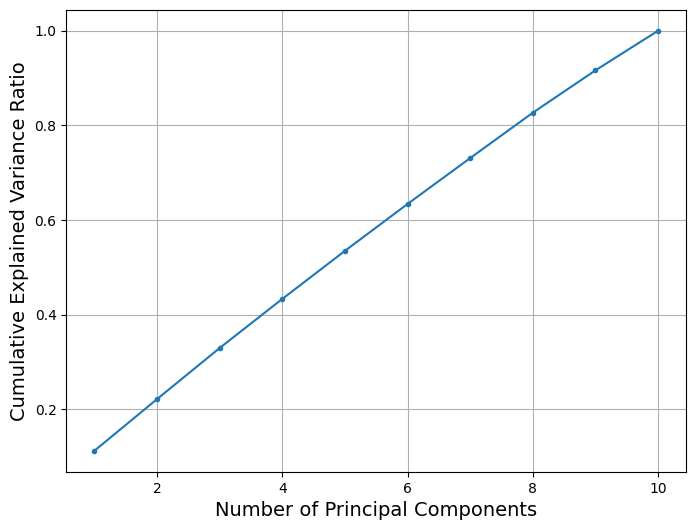

In [9]:
# Generating data
xlimits = np.column_stack((lb,ub))
random_state = 20
sampler = LHS(xlimits=xlimits, criterion='ese', random_state=random_state)

num_train = 50
xtrain = sampler(num_train)
ytrain = f(xtrain)

# Pre-processing data before applying PCA
center = xtrain.mean(axis = 0)
xtrain_center = xtrain - center

# Calculating sum of explained variance ratios
sum_explained_variance_ratio_ = []
n_components = np.arange(1,ndim+1,1)

for component in n_components:
    # Applying PCA to the data
    transform = PCA(n_components=component)
    xprime = transform.fit_transform(xtrain_center)
    sum_explained_variance_ratio_.append(np.sum(transform.explained_variance_ratio_))

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(n_components, sum_explained_variance_ratio_, marker='.')
ax.grid()
ax.set_xlabel('Number of Principal Components', fontsize = 14)
ax.set_ylabel('Cumulative Explained Variance Ratio', fontsize = 14)

The above plot of the cumulative explained variance ratio shows that the cumulative explained variance ratio increases linearly with the number of principal components. This suggests that each of the design variables explains an equal ratio of the variance of the objective function and to satisfy a threshold of 95% cumulative explained variance ratio it will be necessary to select all of the principal components. However, in order to demonstrate the use of dimensionality reduction, five principal components are chosen to represent the objective function. This allows the representation of at least 50% of the variance in the objective which is enough to aid in optimizing the objective function of interest for this section. This will be made clear in the results of the sequential sampling that follow.  

To begin the implementation of sequential sampling using PCA and EI, the block of code below defines the Problem class and differential evolution algorithm for the penalized EI that is to be used for sequential sampling using dimensionality reduction. 

In [6]:
# Problem class
# Upper bound, lower bound and number of variables are added as parameters
class EI_DR(Problem):

    def __init__(self, sm, ymin, lb, ub, n_var, pca, center):
        super().__init__(n_var=n_var, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model
        self.ymin = ymin
        self.pca = pca
        self.center = center
        
    def expected_improvement(self, x):
        
        numerator = self.ymin - self.sm.predict_values(x)
        denominator = np.sqrt( self.sm.predict_variances(x) )
        z = numerator / denominator
        
        return numerator * normal.cdf(z) + denominator * normal.pdf(z)
    
    def penalized_expected_improvement(self, x):
        
        # map back the candidate point to check if it falls inside the original domain
        x_ = self.pca.inverse_transform(x) + self.center
        idx_lower = np.where(x_ < -5.0)
        idx_lower = np.column_stack((idx_lower[0], idx_lower[1]))
        idx_upper = np.where(x_ > 5.0)
        idx_upper = np.column_stack((idx_upper[0], idx_upper[1]))
        
        out = self.expected_improvement(x)
        
        # Assigning a high valued penalty for points that are outside the original bounds of the 
        # problem
        out[idx_lower] = -1000
        out[idx_upper] = -1000

        return out

    def _evaluate(self, x, out, *args, **kwargs):
        
        # Computing expected improvement
        # Negative sign because we want to maximize EI
        out["F"] = - self.penalized_expected_improvement(x) 

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

The block of code below creates 20 training points using the same random state as EI and performs the sequential sampling process using dimensionality reduction and EI. The convergence criterion is set at a maximum number of 45 iterations. At every iteration of the sequential sampling, the data is centered using the mean value. After that, PCA is performed at every iteration of the sampling to reduce the dimensionality of the EI maximization problem using the existing sampling plan at that iteration. 

In [7]:
random_state = 20
sampler = LHS(xlimits=xlimits, criterion='ese', random_state=random_state)

# Training data
num_train = 20
xtrain = sampler(num_train)
ytrain = f(xtrain)

# Variables
itr = 0
max_itr = 45
tol = 1e-3
max_EI = [1]
ybest = []
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
t1 = time.time()
while itr < max_itr:
    
    print("\nIteration {}".format(itr + 1))
    
    # Pre-processing data before applying PCA
    center = xtrain.mean(axis = 0)
    xtrain_center = xtrain - center 

    # Applying PCA to the data
    transform = PCA(n_components=5)
    xprime = transform.fit_transform(xtrain_center)

    # Defining the bounds as the maximum and minimum value of the PC
    lb = xprime.min(axis = 0)
    ub = xprime.max(axis = 0)

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm.set_training_values(xprime, ytrain)
    
    # Creating surrogate model
    sm.train()

    # Find the best observed sample
    ybest.append(np.min(ytrain))

    # Find the minimum of surrogate model
    result = minimize(EI_DR(sm, ybest[-1], lb=lb, ub=ub, n_var = xprime.shape[1], pca = transform, center = center), 
                      algorithm, verbose=False)
    
    # Inverse transform to the real space
    inverse_X = transform.inverse_transform(result.X.reshape(1,-1)) + center
    
    # Computing true function value at infill point
    y_infill = f(inverse_X)

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[np.argmin(ytrain)].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[np.argmin(ytrain)]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, inverse_X ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number

t2 = time.time()
# Printing the final results
print("\nBest obtained point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))

# Storing results
pca_xbest = xbest
pca_ybest = ybest
pca_time = t2 - t1


Iteration 1
Maximum EI: 8.101206122176006
Best observed value: -150.53602901269912

Iteration 2
Maximum EI: 24.35809591219134
Best observed value: -205.46718541728967

Iteration 3
Maximum EI: 9.274252846344787
Best observed value: -205.46718541728967

Iteration 4
Maximum EI: 13.081990715579746
Best observed value: -205.46718541728967

Iteration 5
Maximum EI: 12.99963681917075
Best observed value: -205.46718541728967

Iteration 6
Maximum EI: 16.895842823596272
Best observed value: -205.46718541728967

Iteration 7
Maximum EI: 7.9357712652656325
Best observed value: -205.46718541728967

Iteration 8
Maximum EI: 4.99776176110562
Best observed value: -225.37927694788365

Iteration 9
Maximum EI: 5.00937171312586
Best observed value: -225.37927694788365

Iteration 10
Maximum EI: 3.573573071987613
Best observed value: -243.41727796602

Iteration 11
Maximum EI: 2.234177460314492
Best observed value: -245.7420784175569

Iteration 12
Maximum EI: 0.12434559894876973
Best observed value: -245.74207

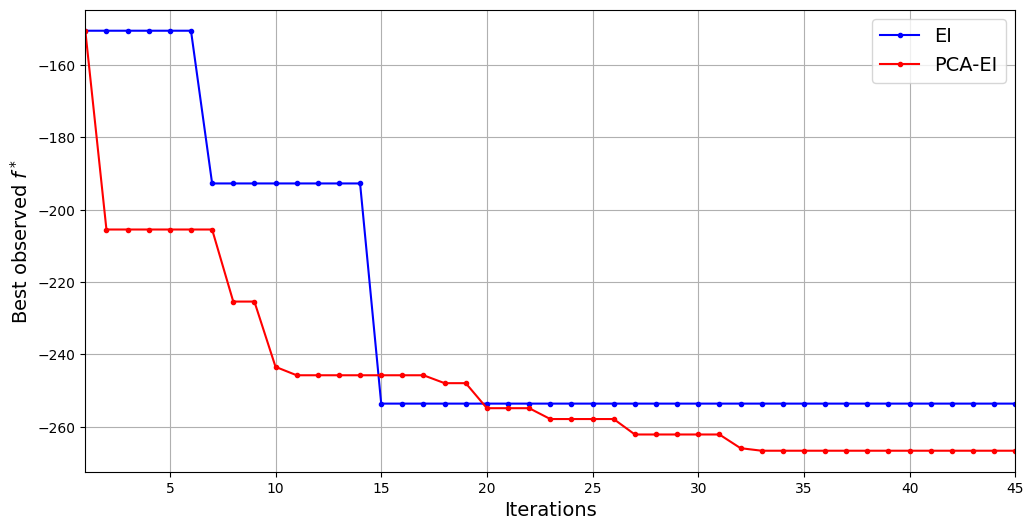

In [8]:
# Plotting and comparing variation of best value of objective function
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(np.arange(itr) + 1, ei_ybest, c="blue", label='EI', marker=".")
ax.plot(np.arange(itr) + 1, ybest, c="red", label='PCA-EI', marker=".")
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Best observed $f^*$", fontsize=14)
ax.legend(fontsize = 14)
ax.set_xlim(left=1, right=itr)
ax.grid()

The above comparison of the best observed function values shows that sequential sampling using PCA provides a benefit over standard EI. It can reduce the best observed function value to approximately -266 which is a greater reduction than standard EI within the same number of maximum iterations. It can also be seen that in this particular run, PCA-EI also reduces the objective function quicker than standard EI. PCA-EI can produce a great reduction in the best observed function value as soon as 10 iterations while it can take standard EI 15 iterations to produce a comparable reduction in the best observed function value.

## Sequential Sampling using Kernel PCA and EI (KPCA-EI)

The blocks of code below will demonstrate the use of Kernel PCA along with EI to optimize the function using sequential sampling. The idea is the same as PCA-EI and the dimensionality of the problem is reduced from 10 to 5 in this case as well. Penalized EI is used to find the new infill point and the parameters of the sampling are identical to those used for EI and PCA-EI. The difference lies in using Kernel PCA as a dimensionality reduction technique. Kernel PCA is a non-linear dimensionality reduction technique often performing better than PCA. However, it is important to correctly choose the hyperparameters of the Kernel PCA algorithm to ensure the best possible performance. Out of these, the most important hyperparameter is the choice of the kernel and other hyperparameters depend on which kernel is chosen for the algorithm. For this demonstration here, the hyperparameters are chosen as the default values with the kernel choice being the cosine kernel. In general, a procedure such as cross-validation can be used to find the best hyperparameters.

In [9]:
random_state = 20
sampler = LHS(xlimits=xlimits, criterion='ese', random_state=random_state)

# Training data
num_train = 20
xtrain = sampler(num_train)
ytrain = f(xtrain)

# Variables
itr = 0
max_itr = 45
tol = 1e-3
max_EI = [1]
ybest = []
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
t1 = time.time()
while itr < max_itr:
    
    print("\nIteration {}".format(itr + 1))
    
    # Pre-processing data before applying KPCA
    center = xtrain.mean(axis = 0)
    xtrain_center = xtrain - center 

    # Applying KPCA to the data
    transform = KernelPCA(n_components=5, kernel='cosine', fit_inverse_transform=True)
    xprime = transform.fit_transform(xtrain_center)
    
    # Defining the bounds as the maximum and minimum value of the PC
    lb = xprime.min(axis = 0)
    ub = xprime.max(axis = 0)

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm.set_training_values(xprime, ytrain)
    
    # Creating surrogate model
    sm.train()

    # Find the best observed sample
    ybest.append(np.min(ytrain))

    # Find the minimum of surrogate model
    result = minimize(EI_DR(sm, ybest[-1], lb=lb, ub=ub, n_var = xprime.shape[1], pca = transform, center = center), 
                      algorithm, verbose=False)
    
    # Inverse transform to the real space
    inverse_X = transform.inverse_transform(result.X.reshape(1,-1)) + center
    
    # Computing true function value at infill point
    y_infill = f(inverse_X)

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[np.argmin(ytrain)].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[np.argmin(ytrain)]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, inverse_X ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number

t2 = time.time()
# Printing the final results
print("\nBest obtained point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))

# Storing time cost results
kpca_time = t2 - t1


Iteration 1
Maximum EI: 6.979328418587719
Best observed value: -150.53602901269912

Iteration 2
Maximum EI: 14.658139415927149
Best observed value: -170.46470349227047

Iteration 3
Maximum EI: 20.1589800042305
Best observed value: -170.46470349227047

Iteration 4
Maximum EI: 23.678652636989206
Best observed value: -170.46470349227047

Iteration 5
Maximum EI: 22.333801998614614
Best observed value: -184.02537973814339

Iteration 6
Maximum EI: 11.787397259763061
Best observed value: -184.02537973814339

Iteration 7
Maximum EI: 8.564722651169953
Best observed value: -200.4633181316592

Iteration 8
Maximum EI: 19.383629111558356
Best observed value: -200.4633181316592

Iteration 9
Maximum EI: 11.598636620415027
Best observed value: -200.4633181316592

Iteration 10
Maximum EI: 27.777033778937273
Best observed value: -200.741739458622

Iteration 11
Maximum EI: 17.476895468219578
Best observed value: -222.47232321053272

Iteration 12
Maximum EI: 2.828804966837966
Best observed value: -226.77

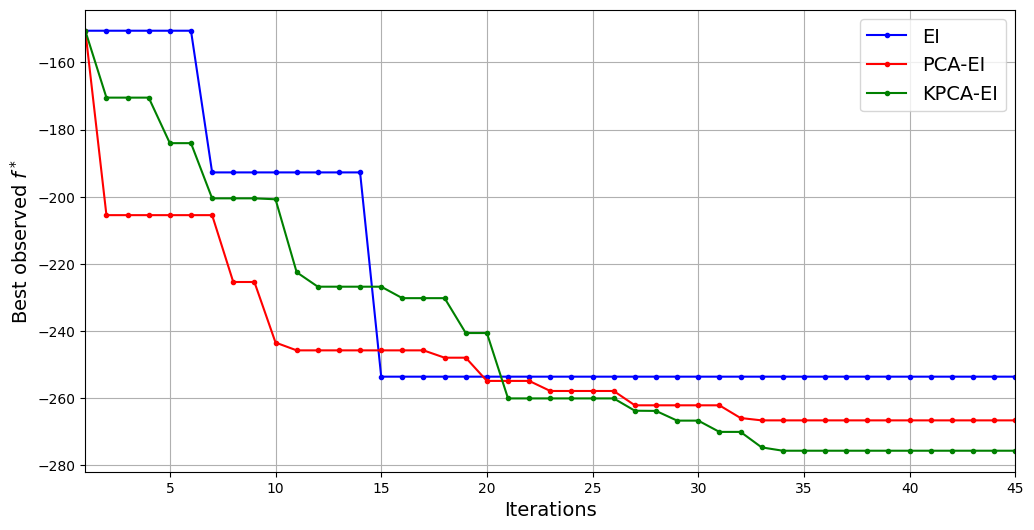

In [12]:
# Plotting and comparing variation of best value of objective function
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(np.arange(itr) + 1, ei_ybest, c="blue", label='EI', marker=".")
ax.plot(np.arange(itr) + 1, pca_ybest, c="red", label='PCA-EI', marker=".")
ax.plot(np.arange(itr) + 1, ybest, c="green", label='KPCA-EI', marker=".")
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Best observed $f^*$", fontsize=14)
ax.legend(fontsize = 14)
ax.set_xlim(left=1, right=itr)
ax.grid()

The above plot shows that KPCA-EI can produce a reduction in the best observed value of the function which is greater than both standard EI and PCA-EI. KPCA-EI is able to reduce the best observed value to approximately -275. It is, therefore, the best performing method in this run according to the best observed value of the objective function. However, in this run, it is not as quick as PCA-EI and standard EI to reduce the objective function value. In fact, it can take almost 21 iterations for KPCA-EI to produce a reduction in the objective that is comparable to standard EI and PCA-EI. It is also important to remember that the performance of KPCA-EI depends on the choice of hyperparameters for KPCA which significantly affect the dimensionality reduction and performance of the algorithm. 

The final block of code below shows the total time cost of each of the sequential sampling algorithms shown in this section. The results show that the use of dimensionality reduction techniques reduces the overall time cost of sequentially sampling a high-dimensional function. 

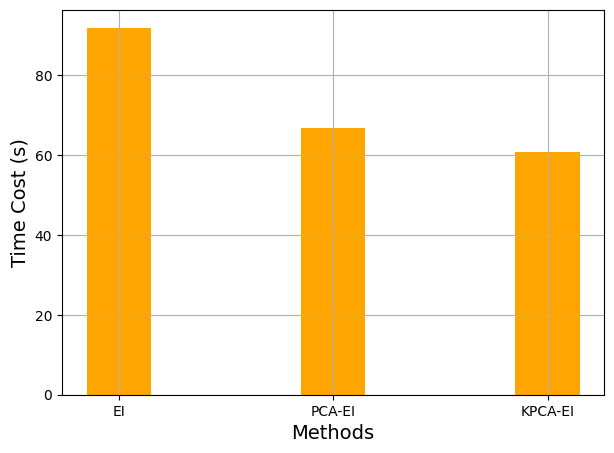

In [13]:
fig, ax = plt.subplots(figsize=(7,5))
methods = ['EI', 'PCA-EI', 'KPCA-EI']
times = [ei_time, pca_time, kpca_time]
ax.bar(methods, times, color ='orange', width = 0.3)
ax.set_xlabel("Methods", fontsize = 14)
ax.set_ylabel("Time Cost (s)", fontsize = 14)
ax.grid()